In [1]:
# import our python modules
import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import numpy as np
import matplotlib.pyplot as plt
get_ipython().magic('matplotlib inline')
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.plots as plots
from astropy.table import Table, Column
from scipy import optimize
import json

In [2]:
# Set the database and query
runName = 'minion_1016'
opsdb = db.OpsimDatabase(runName + '_sqlite.db')

# Set the output directory
outDir = 'Observations Dictionary'
resultsDb = db.ResultsDb(outDir)

In [90]:
# Set desired filters, range of location and mangitudes of peak, and sample light curve here
filterNames = ['g', 'r', 'i', 'z']
colors = {'u':'cyan','g':'g','r':'blue','i':'r','z':'m', 'y':'k'}
#Consider red filter for the two below
#location_of_peak = np.arange(0,50, 10)
#height_of_peak = np.arange(16, 18, 0.5)
location_of_peak = [10]
height_of_peak = [17]
jsonLC = 'iPTF13bvn.json'

In [112]:
# The pass metric just passes data straight through.
#choose database and restrictions (such as list of ra and dec)
metric = metrics.PassMetric(cols=['expMJD','filter','fiveSigmaDepth'])
slicer = slicers.UserPointsSlicer(np.random.uniform(0,360,200), np.random.uniform(-60,-30,200))
#no restrictions currently
sql = ''
bundle = metricBundles.MetricBundle(metric,slicer,sql)
bg =  metricBundles.MetricBundleGroup({0:bundle}, opsdb,
                                        outDir=outDir, resultsDb=resultsDb)
bg.runAll()

Querying database with no constraint.
Found 2447931 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [5]:
def createdict_for_mjd_filter_depth(bundle):
    
    """This function returns a list of tables of exposure day, filter, 
    and five sigma depth for each ra and dec chosen"""
    
    listofDict = []
    for coord in range(len(bundle.metricValues)):
        bdict = {key: bundle.metricValues[coord][key] for 
                 key in ['fieldRA', 'fieldDec', 'expMJD', 'filter', 'fiveSigmaDepth']}
        t = Table(bdict)
        t.rename_column('expMJD', 'day')
        listofDict.append(t)
    return listofDict

In [88]:
class ReadCurve():
    #Read in asciifile and interpolate data for each filter
    
    def __init__(self, jsonfile):
        self.read_lightcurve(jsonfile)

    def read_lightcurve(self, jsonfile):
        # Open and load json file with sne values
        sne_data = open(jsonfile)
        sne = json.load(sne_data)
        # Set up dictionary for json data
        data = {'day': [], 'filter': [], 'mag': [], 'magerror': [], 'upperlimit': []}
        # Use for loop to call to values within the json file
        for entry in sne['iPTF13bvn']['photometry']:
            # Ignore instances in which 'band' and 'magnitude' have no data
            if 'band' in entry and 'magnitude' in entry:
                data['day'].append(float(entry['time']))
                data['filter'].append(entry['band'])
                data['mag'].append(float(entry['magnitude']))
                # Ignore instances in which 'upperlimit' has no value (i.e. is 'false')
                if 'upperlimit' in entry:
                    data['upperlimit'].append(entry['upperlimit'])
                else:
                    data['upperlimit'].append(False)
                # Ignore instances in which 'e_magnitude' has no value (i.e. upperlimit IS the error)
                if 'e_magnitude' in entry:
                    data['magerror'].append(float(entry['e_magnitude']))
                else:
                    data['magerror'].append(99)
        # Table the now-full dictionary of sne data
        sne_table = Table(data)
        # Update the table to modify the data for magnitude errors no more than 0.3, no upperlimit values,
        # mjd in terms of obvservation day number, and filters in only g, r, i, and z.
        sne_table = sne_table[sne_table['magerror'] < 0.3]
        sne_table = sne_table[sne_table['upperlimit'] == False]
        sne_table = sne_table[sne_table['filter'] != 'V']
        sne_table = sne_table[sne_table['filter'] != 'R']
        sne_table = sne_table[sne_table['filter'] != 'W1']
        sne_table = sne_table[sne_table['filter'] != 'B']
        sne_table = sne_table[sne_table['filter'] != 'U']
        sne_table = sne_table[sne_table['filter'] != 'I']
        sne_table = sne_table[sne_table['filter'] != 'W2']
        sne_table['day'] = sne_table['day'] - sne_table['day'].min()
        sne_table = sne_table['day', 'filter', 'mag', 'magerror']
        return sne_table

In [7]:
def interpolate_light_curve(adjusted_lc_table, survey):
    
    #for each filter interpolate the read in light curve to the days of the survey in all filters
    
    lc = {}
    for f in filterNames:
        fMatch = np.where(adjusted_lc_table['filter'] == f)
        lc[f] = np.interp(survey['day'], adjusted_lc_table['day'][fMatch], adjusted_lc_table['mag'][fMatch])
    lightcurve = Table(lc)
    lightcurve['day'] = survey['day']
    lightcurve = lightcurve['day', 'g', 'r', 'i', 'z']
    return lightcurve

In [8]:
def resample_light_curve(lightcurve, opsim):
    
    """add to the opsim table a magnitude column where the magnitude is taken 
    from the index of the interpolated light curve where both the filter and day matched the opsim"""
    opsim1 = opsim.copy()
    opsim1['magnitude'] = 0.
    for row in range(len(opsim1)):
        filterName = opsim1['filter'][row]
        opsim1['magnitude'][row] = lightcurve[filterName][row]
    opsim1 = opsim1['day','filter','magnitude','fiveSigmaDepth']
    opsim1.sort('day')
    return opsim1

In [9]:
def peak_brightness(lc_table):
    
    """This function returns a table of peak magnitude and the day it occurs 
    for each filter from the read in lightcurve"""
    
    peak_brightness = {}
    for f in filterNames:
        fMatch = np.where(lc_table['filter'] == f)
        maxmag = np.amin(lc_table['mag'][fMatch])
        location = np.argmin(lc_table['mag'][fMatch])
        maxday = lc_table['day'][fMatch][location]
        peak_brightness[f] = [maxday, maxmag]
    
    peak = Table(peak_brightness)
    peak[' '] = ['day', 'magnitude']
    orderedPeak = peak[' ','g','r','i','z']
    return orderedPeak

In [10]:
def organize_opsim_table(survey, coord):
    opsim = list(survey)
    opsim = opsim[coord]
    opsim = opsim['fieldRA', 'fieldDec', 'day', 'filter', 'fiveSigmaDepth']
    opsim = opsim[opsim['filter'] != 'u']
    opsim = opsim[opsim['filter'] != 'y']
    opsim['day'] = (opsim['day'] - opsim['day'].min())
    opsim.sort('day')
    return opsim

In [11]:
def adjust_peak(lc_table, peaktable, peakday, peakmag):
    
    """This function finds the necessary adjustment needed to make the peak 
    of the red filter occur at the right place and adjusts all filters by that same ammount"""
    adjusted_lc_table = lc_table.copy()
    
    peak_day_difference = peaktable['r'][0] - peakday
    adjusted_lc_table['day'] = adjusted_lc_table['day'] - peak_day_difference
    
    peak_mag_difference = peaktable['r'][1] - peakmag
    adjusted_lc_table['mag'] = adjusted_lc_table['mag'] - peak_mag_difference
    
    return adjusted_lc_table

In [12]:
def adjust_opsim_table(opsim, adjusted_lc_table):
    new_opsim = opsim.copy()
    new_opsim = new_opsim[new_opsim['day']< adjusted_lc_table['day'].max()]
    new_opsim = new_opsim[new_opsim['day']> adjusted_lc_table['day'].min()]
    return new_opsim

In [13]:
def calculate_error(survey):
    
    #Calculate the error of the magnitude at each point from the magnitude and fiveSigmaDepth stored in survey
    
    snr = 5.*10.**(-0.4*(survey['magnitude'] - survey['fiveSigmaDepth']))
    lc_err = 2.5/(np.log(10)*snr)
    survey['error'] = lc_err
    
    return survey

In [14]:
def plot_light_curve(opsim_fmatch2, f, ra, dec, day, mag):
    
    #Plot the resampled light curve (day vs. magnitude) with error for each filter
    fig, ax = plt.subplots(1,1)
    ax.errorbar(opsim_fmatch2['day'], opsim_fmatch2['magnitude'], opsim_fmatch2['error'],
                fmt = 'o', color=colors[f])
    ax.set_ylim(20,15)
    ax.set_xlim(0,365)
    ax.set_xlabel('Days')
    ax.set_ylabel('Magnitude')
    handles, labels = ax.get_legend_handles_labels()
    handles = [h[0] for h in handles]
    ax.legend(handles, [f for f in filterNames], fontsize='smaller', numpoints=1)
    ax.set_title('Resampled Light Curve for ra = %r and dec = %r and peakday = %d and peakmag = %d' 
                 %(ra, dec, day, mag))

In [15]:
def interpolate_original(lc_table, times):
    lc_original = {}
    #for each filter plot the corresponding light curve created in Make_LightCurve
    for f in filterNames:
        fMatch = np.where(lc_table['filter'] == f)
        lc_original[f] = np.interp(times, lc_table['day'][fMatch], lc_table['mag'][fMatch])
    lightcurve2 = Table(lc_original)
    lightcurve2['day'] = times
    lightcurve2 = lightcurve2['day', 'g', 'r', 'i', 'z']
    return lightcurve2

In [16]:
def change_lightcurve_to_table(lightcurve2):
    
    opsim2 = Table()
    opsim2.add_column(Column(name='day'))
    opsim2.add_column(Column(name='mangitude'))
    opsim2.add_column(Column(name='filter'))
    opsim2 = Table(names=('day', 'magnitude', 'filter'), dtype=('float', 'float', 'string'))
    for day in lightcurve2['day']:
        for f in filterNames:
            row = np.where(lightcurve2['day'] == day)
            opsim2.add_row([day, lightcurve2[f][row][0], f])            
    return opsim2

In [17]:
def func2(x, a, b, c, d, e):
    return a*x**4 + b*x**3 + c*x**2 + d*x + e

In [18]:
def create_curve2(opsim_fmatch2, opsim_fmatch3, f, adjusted_lc_table, ra, dec, peakday, peakmag):
    curve = np.copy(opsim_fmatch2)
    curve = Table(curve)
    fMatch = np.where(adjusted_lc_table['filter'] == f)
    curve = curve[curve['day'] <= adjusted_lc_table['day'][fMatch].max()]

    survey2 = np.copy(opsim_fmatch3)
    survey2 = Table(survey2)
    survey2 = survey2[survey2['day'] <= adjusted_lc_table['day'][fMatch].max()]

    xdata = np.arange(0, curve['day'].max(), 1)
    popt, pcov = optimize.curve_fit(func2, curve['day'], curve['magnitude'])
    plt.plot(xdata, func2(xdata, *popt), 'orange' , label='fit')
    plt.errorbar(curve['day'], curve['magnitude'], 
               yerr = curve['error'], fmt = 'o', color=colors[f], label=f)
    plt.plot(survey2['day'], survey2['magnitude'], color=colors[f], label=f)
    plt.xlabel('day')
    plt.ylabel('magnitude')
    plt.ylim(20,15)
    plt.legend(numpoints = 1)
    plt.title('Lightcurve at ra = %r and dec = %r, peakday = %r and peakmag = %r'
              %(ra, dec, peakday, peakmag))
    plt.show()

In [19]:
def resampled_peak_magnitude(opsim_fmatch2, f, adjusted_lc_table, ra, dec):
  
    fMatch = np.where(adjusted_lc_table['filter'] == f)

    survey = np.copy(opsim_fmatch2)
    survey = Table(survey)
    survey = survey[survey['day'] <= adjusted_lc_table['day'][fMatch].max()]

    xdata = np.arange(0, survey['day'].max(), 2)
    popt, pcov = optimize.curve_fit(func2, survey['day'], survey['magnitude'])

    peak_magnitude_difference = abs(adjusted_lc_table['mag'].min() - func2(xdata, *popt).min())
    
    return [ra, dec, f, peak_magnitude_difference]

In [20]:
def resampled_peak_day(opsim_fmatch2, f, adjusted_lc_table, ra, dec):

    fMatch = np.where(adjusted_lc_table['filter'] == f)

    survey = np.copy(opsim_fmatch2)
    survey = Table(survey)
    survey = survey[survey['day'] <= adjusted_lc_table['day'][fMatch].max()]

    xdata = np.arange(0, survey['day'].max() + 10, 1)
    popt, pcov = optimize.curve_fit(func2, survey['day'], survey['magnitude'])

    actual_peak_day = adjusted_lc_table['day'][adjusted_lc_table['mag'].argmin()]
    fitted_peak_day = func2(xdata, *popt).argmin()
    peak_day_difference = abs(actual_peak_day - fitted_peak_day)
    
    return [ra, dec, f, peak_day_difference]

In [21]:
def peak_difference(peak):
    peak_difference = Table()
    peak_difference.add_column(Column(name='ra'))
    peak_difference.add_column(Column(name='dec'))
    peak_difference.add_column(Column(name='filter'))
    peak_difference.add_column(Column(name= peak))
    peak_difference = Table(names=('ra', 'dec', 'filter', peak), 
                                dtype=('float', 'float', 'string', 'float'))
    return peak_difference

In [99]:
def table_percent_with_enough():
    percent_table = Table()
    percent_table.add_column(Column(name='ra'))
    percent_table.add_column(Column(name='dec'))
    percent_table.add_column(Column(name='percent'))
    percent_table = Table(names=('ra', 'dec', 'percent'), 
                                dtype=('float', 'float', 'float'))
    return percent_table

/home/hbowden/lsst4/Linux64/miniconda2/4.2.12.lsst1/lib/python2.7/site-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


      ra           dec       filter peak magnitude difference
------------- -------------- ------ -------------------------
2.54393261038 -53.4684214416      z            0.181151375476
271.696586451 -55.2216722947      z            0.129190466906
49.5608492788 -51.7610072121      g            0.551965371372
49.5608492788 -51.7610072121      i            0.496890998967
49.5608492788 -51.7610072121      z            0.139370324908
 5.4946652553 -55.9779765843      z            0.180787284576
192.794568484 -48.9649731719      z             1.47144631447
235.634622826 -46.8794067976      i            0.245289414974
270.401701834 -52.4600157222      z            0.130485507626
149.496147906 -55.9779765843      z            0.202576770647
          ...            ...    ...                       ...
235.634622826 -46.8794067976      i            0.246121390447
29.2838729091 -34.0795296544      z             2.57327284949
269.662586278 -38.8866455555      z            0.286619570314
341.3052

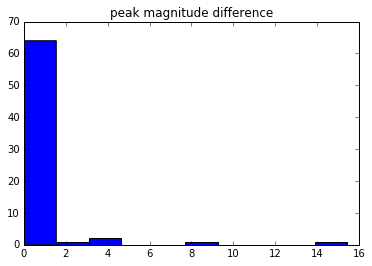

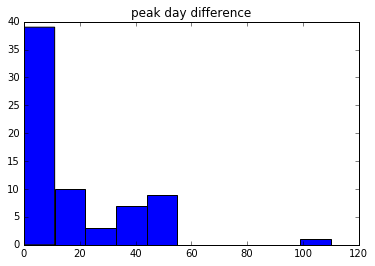

In [113]:
read_curve = ReadCurve(jsonLC)
lc_table = read_curve.read_lightcurve(jsonLC)
peakTable = peak_brightness(lc_table)
survey = createdict_for_mjd_filter_depth(bundle)
percent_table = table_percent_with_enough()
peak1 = 'peak magnitude difference'
peak2 = 'peak day difference'
peak_mag_difference = peak_difference(peak1)
peak_day_difference = peak_difference(peak2)
enough = 0.
not_enough = 0.
for coord in range(len(bundle.metricValues)):
    #enough = 0.
    #not_enough = 0.
    opsim = organize_opsim_table(survey, coord)
    
    ra = np.degrees(round(opsim['fieldRA'][0], 4))
    dec = np.degrees(round(opsim['fieldDec'][0], 4))
    
    for peakday in location_of_peak:
        for peakmag in height_of_peak:
            adjusted_lc_table = adjust_peak(lc_table, peakTable, peakday, peakmag)
            new_opsim = adjust_opsim_table(opsim, adjusted_lc_table)
            lightcurve = interpolate_light_curve(adjusted_lc_table, new_opsim)
            opsim1 = resample_light_curve(lightcurve, new_opsim)
            opsim1 = calculate_error(opsim1)
            
            times = np.arange(new_opsim['day'].min(), new_opsim['day'].max(), 1)
            lightcurve2 = interpolate_original(adjusted_lc_table, times)
            opsim2 = change_lightcurve_to_table(lightcurve2)
            
            final_opsim = opsim1.copy()
            final_opsim = final_opsim[final_opsim['day'] <= 30]
            for f in filterNames:
                fMatch = np.where(final_opsim['filter'] == f)
                fMatch2 = np.where(opsim1['filter'] == f)
                fMatch3 = np.where(opsim2['filter'] == f)
                opsim_fmatch = final_opsim[fMatch]
                opsim_fmatch['day'] = np.round(opsim_fmatch['day'])
                opsim_fmatch2 = opsim1[fMatch2]
                opsim_fmatch3 = opsim2[fMatch3]
                if len(np.unique(opsim_fmatch['day'])) >= 4:
                    #print('enough points for filter = %s, ra = %r, dec = %r' %(f, ra, dec))
                    #plot_light_curve(opsim_fmatch2, f, ra, dec, peakday, peakmag)
                    #create_curve2(opsim_fmatch2, opsim_fmatch3, 
                    #              f, adjusted_lc_table, ra, dec, peakday, peakmag)
                    peak_mag_list = resampled_peak_magnitude(opsim_fmatch2, f, adjusted_lc_table, ra, dec)
                    peak_mag_difference.add_row(peak_mag_list)
                    peak_day_list = resampled_peak_day(opsim_fmatch2, f, adjusted_lc_table, ra, dec)
                    peak_day_difference.add_row(peak_day_list)
                    enough += 1
                else:
                    not_enough += 1
    percent_with_atleast_4 = enough/(enough + not_enough)*100
    percent_table.add_row([ra, dec, percent_with_atleast_4])
#print percent_table
print peak_mag_difference
plt.figure()
plt.hist(peak_mag_difference['peak magnitude difference'])
plt.title('peak magnitude difference')
print peak_day_difference
plt.figure()
plt.hist(peak_day_difference['peak day difference'])
plt.title('peak day difference')
print('enough = %d' %(enough))
print('not enough = %d' %(not_enough))

In [85]:
class Test():
    def __init__(self):
        
        pass
    
    def createdict_for_mjd_filter_depth_test(self, bundle):
        
        survey = createdict_for_mjd_filter_depth(bundle)
        survey_test_0 = survey[0]
        survey_test_0 = survey_test_0['fieldRA', 'fieldDec', 'day', 'filter', 'fiveSigmaDepth']
        survey_test_1 = survey[1]
        survey_test_1 = survey_test_1['fieldRA', 'fieldDec', 'day', 'filter', 'fiveSigmaDepth']
        assert ((survey_test_0[0][0] == bundle.metricValues[0][0][2]) 
                and (survey_test_1[1][1] == bundle.metricValues[1][1][4]))
        print('createdict_for_mjd_filter_depth works')
        
    def read_lightcurve_test(self, jsonLC):
        
        #Check with fake data file (test_data.json)
        read_curve = ReadCurve(jsonLC)
        lc_table = read_curve.read_lightcurve(jsonLC)
        assert lc_table['mag'].min() == 19.5
        assert lc_table['day'].min() == 0
        print('read_lightcurve works')
        
    def peak_brightness_test(self):
        
        read_curve = ReadCurve(jsonLC)
        lc_table = read_curve.read_lightcurve(jsonLC)
        peaktable = peak_brightness(lc_table)
        assert peaktable['g'][1] == 19.5
        print('peak_brightness works')

    def adjust_peak_test(self):
        
        read_curve = ReadCurve(jsonLC)
        lc_table = read_curve.read_lightcurve(jsonLC)
        adjusted_lc_table = np.copy(lc_table)
        peaktable = peak_brightness(lc_table)
        peakday = 10
        peakmag = 16
        adjusted_lc_table = adjust_peak(adjusted_lc_table, peaktable, peakday, peakmag)
        for f in filterNames:
            fMatch = np.where(lc_table['filter'] == f)
            assert (np.all((lc_table['mag'][fMatch] - 3.7) == adjusted_lc_table['mag'][fMatch]) 
                   and np.all((lc_table['day'][fMatch] - 41) == adjusted_lc_table['day'][fMatch]))
        print('adjust_peak works')
        
    def interpolate_original_test(self, lc_table, times):
        
        lightcurve = interpolate_original(lc_table, times)
        rise = lightcurve['g'][0] - lightcurve['g'].min()
        location_of_min = lightcurve['g'].argmin()
        run = lightcurve['day'][location_of_min] - lightcurve['day'][0]
        slope = rise/run
        assert np.absolute(slope - 0.05) <= 0.01
        print('interpolate_original works')
        
    def calculate_error_test(self):
        
        a = [16, 17, 18, 19]
        b = [21, 24, 22, 23.5]
        t= Table([a, b], names=('magnitude', 'fiveSigmaDepth'))
        test_survey = calculate_error(t)
        assert np.absolute(test_survey['error'][0] - 0.00217) <= 0.00001
        assert np.absolute(test_survey['error'][1] - 0.000344) <= 0.00001
        assert np.absolute(test_survey['error'][2] - 0.00545) <= 0.00001
        assert np.absolute(test_survey['error'][3] - 0.00344) <= 0.00001
        print('calculate_error works') 
        
    def resampled_peak_magnitude_test(self, opsim, lc_table):
        
        opsim_fmatch2 = opsim[opsim['filter'] == 'z']
        f = 'z'
        ra = 0
        dec = -15
        peak = resampled_peak_magnitude(opsim_fmatch2, f, lc_table, ra, dec)
        assert peak[3] <= 0.001
        print('resampled_peak_magnitude works')
        
    def resampled_peak_day_test(self, opsim, lc_table):
        
        opsim_fmatch2 = opsim[opsim['filter'] == 'z']
        f = 'z'
        ra = 0
        dec = -15
        peak = resampled_peak_day(opsim_fmatch2, f, lc_table, ra, dec)
        assert peak[3] <= 0.001
        print ('resampled_peak_day works')
        
    def adjust_opsim_table_test(self, opsim, new_lc_table):
        
        adjusted_opsim = adjust_opsim_table(opsim, new_lc_table)
        assert adjusted_opsim['day'].max() <= 82
        print ('adjust_opsim_table works')

In [86]:
jsonLC = 'test_data.json'
test = Test()
test.createdict_for_mjd_filter_depth_test(bundle)
test.read_lightcurve_test(jsonLC)
test.peak_brightness_test()
test.adjust_peak_test()
test.calculate_error_test()

read_curve = ReadCurve(jsonLC)
lc_table = read_curve.read_lightcurve(jsonLC)
survey = createdict_for_mjd_filter_depth(bundle)
opsim = organize_opsim_table(survey, 0)
times = np.arange(lc_table['day'].min(), lc_table['day'].max(), 1)
test.interpolate_original_test(lc_table, times)

createdict_for_mjd_filter_depth works
read_lightcurve works
peak_brightness works
adjust_peak works
calculate_error works
interpolate_original works


In [87]:
#create new fake_data (straight line)
new_lc_table = Table()
new_lc_table.add_column(Column(name='day'))
new_lc_table.add_column(Column(name='filter'))
new_lc_table.add_column(Column(name='mag'))
new_lc_table.add_column(Column(name= 'magerror'))
new_lc_table = Table(names=('day', 'filter', 'mag', 'magerror'), 
                            dtype=('float', 'string', 'float', 'float'))
x = 0
while x < 82.6:
    new_lc_table.add_row([x, 'z', x, 0])
    x += 1
new_lc_table.add_row([0, 'g', 0, 0])
new_lc_table.add_row([0, 'r', 0, 0])
new_lc_table.add_row([0, 'i', 0, 0])
new_lc_table.add_row([0, 'z', 0, 0])
new_opsim = adjust_opsim_table(opsim, new_lc_table)
lightcurve = interpolate_light_curve(new_lc_table, new_opsim)
opsim = resample_light_curve(lightcurve, new_opsim)

test.resampled_peak_magnitude_test(opsim, new_lc_table)
test.resampled_peak_day_test(opsim, new_lc_table)
test.adjust_opsim_table_test(opsim, new_lc_table)

resampled_peak_magnitude works
resampled_peak_day works
adjust_opsim_table works
